# Conditional likelihoods of trajectories

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pathlib
from scipy import stats, interpolate
from numba import guvectorize,float64

import os
import glob

In [2]:
matplotlib.rc_file_defaults()

In [3]:
from analyzer import analyzer

In [51]:
run = 10
paths = glob.glob(os.path.expandvars('$HOME/run{}/*'.format(run)))
mutual_informations = np.concatenate([np.load(p) for p in paths])
num_r, _, length = mutual_informations.shape
mutual_informations.shape

(100, 2, 49999)

In [119]:
offset = 300

x = np.linspace(np.max(mutual_informations[:,0,0])+offset,np.min(mutual_informations[:,0,-1]),50000)
timespan = x.max() - x.min()
mi = np.zeros((num_r, len(x)))
for i, old in enumerate(mutual_informations):
    mi[i] = np.interp(x, old[0], old[1])
x=x-offset
mi_mean = np.mean(mi, axis=0)

In [120]:
def subset_indices(num_responses, subset_signals, subset_responses):
    assert subset_responses <= num_responses
    indices = np.zeros((subset_signals * subset_responses, 2), dtype=int)
    for s in range(subset_signals):
        for r in range(subset_responses):
            indices[s*subset_responses + r] = [s, r]
    return indices.T
    

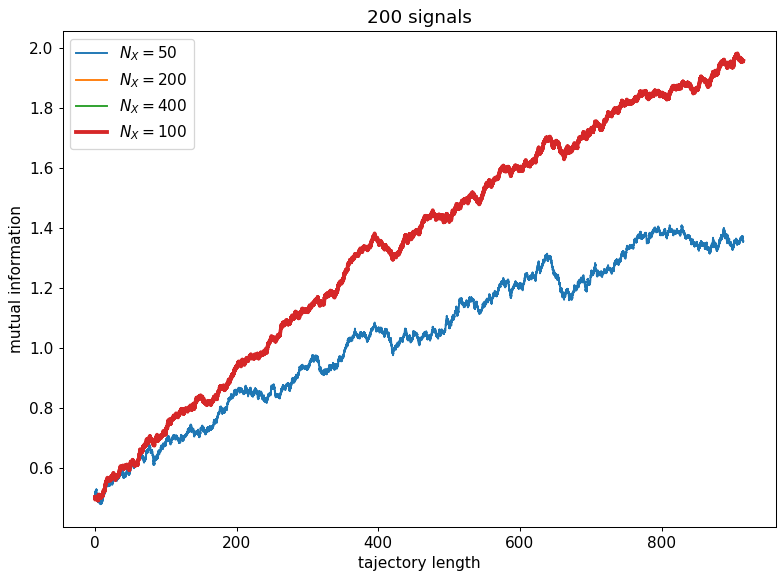

In [121]:
for r in [50, 200, 400]:
    subset_mean = np.mean(mi[:r], axis=0)
    plt.plot(x, subset_mean, label='$N_X={}$'.format(r))
plt.plot(x, mi_mean, label='$N_X={}$'.format(num_r), linewidth=3)
plt.legend()
plt.title('200 signals')
plt.ylabel('mutual information')
plt.xlabel('tajectory length');

In [122]:
numerical_x = np.array([6.10351562e-01, 1.22070312e+00, 2.44140625e+00, 4.88281250e+00,
       9.76562500e+00, 1.95312500e+01, 3.90625000e+01, 7.81250000e+01,
       1.56250000e+02, 3.12500000e+02, 6.25000000e+02, 1.25000000e+03,
       2.50000000e+03])
numerical = np.array([0.07155042, 0.07221034, 0.07352942, 0.07616464, 0.08142376,
       0.09190024, 0.1127109 , 0.15391634, 0.23541893, 0.39725253,
       0.72029812, 1.36630923, 2.65833046])

In [123]:
def mut_inf(lamda, rho):
    return lamda/2 * (np.sqrt(1 + rho/lamda) - 1)
from scipy.optimize import curve_fit
def linear(t, inf_rate, offset):
    return t * inf_rate + offset

def rate_from_curve(x, y):
    (rate, offset), _ = curve_fit(linear, x, y, sigma=np.exp(-x/np.max(x)))
    return rate, offset


theoretical_rate = mut_inf(0.005, 0.005)
rate, offset = rate_from_curve(x, mi_mean)
rate_numerical, _ = rate_from_curve(numerical_x, numerical)
print("analytical:  {}\nnumerical:   {}\nmonte carlo: {}".format(theoretical_rate, rate_numerical, rate))

analytical:  0.0010355339059327378
numerical:   0.0010345131030511097
monte carlo: 0.0014846639597421109


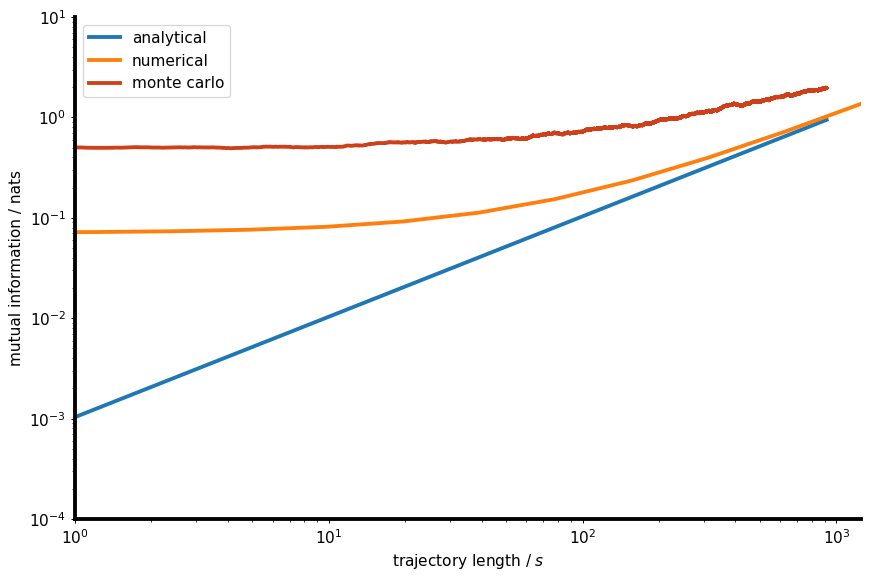

In [124]:
matplotlib.rcParams.update({'font.size': 12, 'font.family': 'TeX Gyre Heros'})
plt.plot(x, theoretical_rate*x, label='analytical', linewidth=3)
plt.plot(numerical_x, numerical, linewidth=3, label='numerical')

plt.plot(x, mi_mean, label='monte carlo', linewidth=3, color='#CD401A')

plt.xlim(1,1250)

ax = plt.gca()
for pos in ['right', 'top']:
    ax.spines[pos].set_visible(False)
    
for pos in ['left', 'bottom']:
    ax.spines[pos].set_linewidth(3)

plt.ylabel('mutual information / nats')
plt.xlabel('trajectory length $/\\; s$')
plt.legend()

plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-4,1e1)

plt.gcf().set_size_inches(28/2.54, 18/2.54)
plt.savefig('poster_plot_3.pdf')

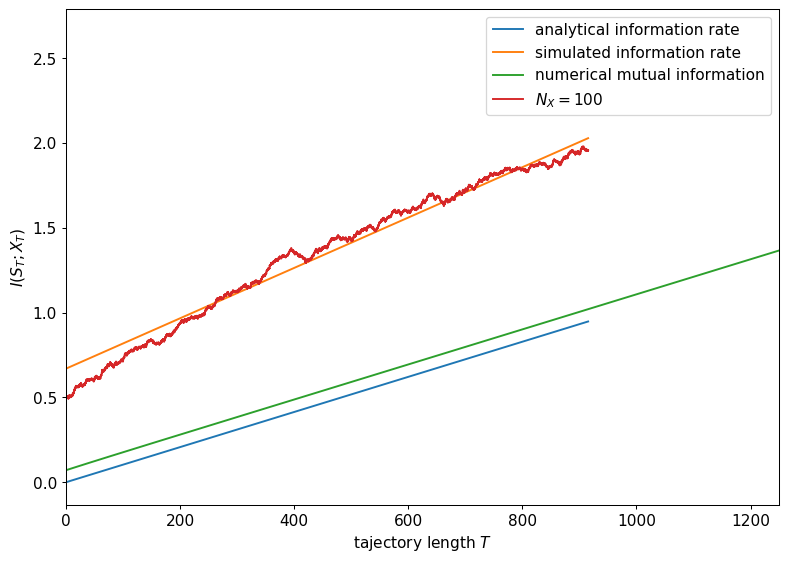

In [125]:
plt.plot(x, theoretical_rate*x, label='analytical information rate')
plt.plot(x, linear(x, rate, offset), label='simulated information rate')
plt.plot(numerical_x, numerical, label='numerical mutual information')
plt.plot(x, mi_mean, label='$N_X={}$'.format(num_r))
plt.ylabel('$I(S_T;X_T)$')
plt.xlabel('tajectory length $T$')
plt.xlim(0,1250)
plt.legend();

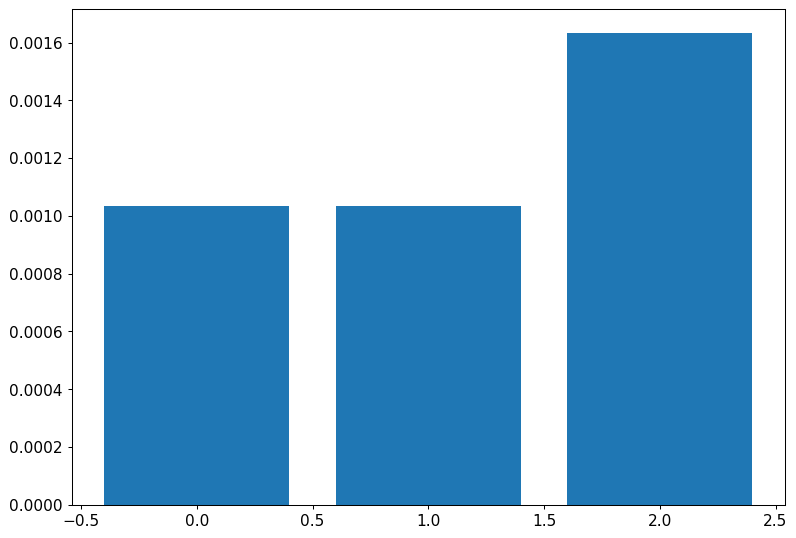

In [63]:
plt.bar(x=np.arange(3), height=[theoretical_rate, rate_from_curve(numerical_x, numerical)[0], rate_from_curve(x, mi_mean)[0]]);

In [22]:
def mov_avrg(x, y, n=3):
    return x[n:], (y[n:] - y[:-n]) / (x[n:] - x[:-n])

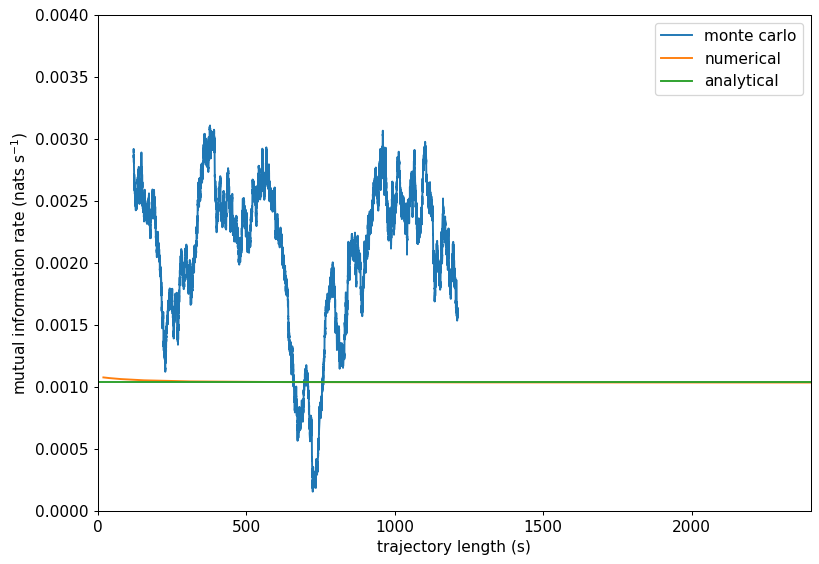

In [25]:
new_x, new_y = mov_avrg(x, mi_mean, 5000)
plt.plot(new_x, new_y, label='monte carlo')
new_x, new_y = mov_avrg(numerical_x, numerical, 5)
plt.plot(new_x, new_y, label='numerical')
plt.plot([0,2500], [theoretical_rate, theoretical_rate], label='analytical')
plt.ylim(0, 0.004)
plt.xlim(0, 2400)
plt.ylabel('mutual information rate (nats $\mathrm{s}^{-1}$)')
plt.xlabel('trajectory length (s)')
plt.legend();

In [14]:
from pathlib import Path
signal = analyzer.load_trajectory(Path('/data/signal/sig1.traj'))

Define the reactions

In [16]:
from analyzer import stochastic_sim

reaction_k = np.array([0.005, 0.02])
reaction_reactants = np.array([[0], [1]])
reaction_products = np.array([[0, 1], [-1, -1]])

length = 100000
num_responses = 3

timestamps = np.zeros((num_responses, length))
trajectory = np.empty((num_responses, 1, length))
trajectory[...,0] = 1000.0
reaction_events = np.empty((num_responses, length), dtype='i4')

ext_components = signal['components']['S'].reshape((1,-1))
ext_timestamps = signal['timestamps']

In [17]:
stochastic_sim.simulate(timestamps, trajectory, ext_components, ext_timestamps,
                            reaction_k, reaction_reactants, reaction_products, reaction_events)

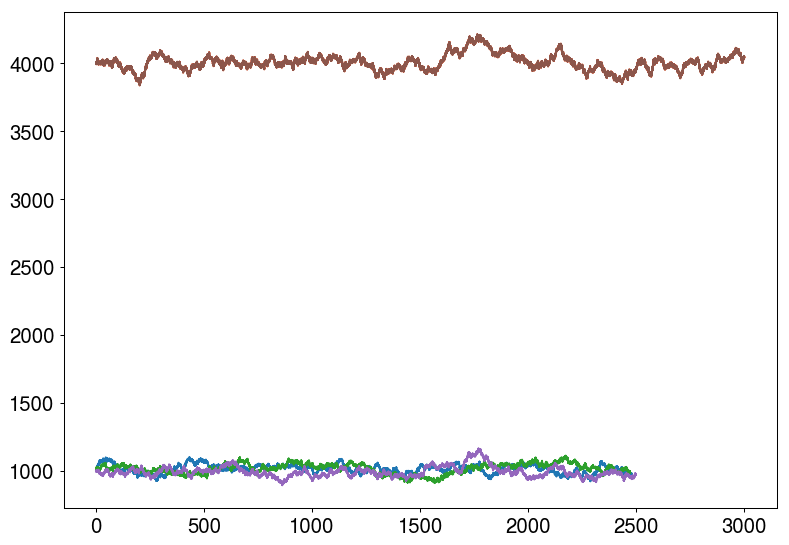

In [18]:
for t, x in zip(timestamps, trajectory):
    plt.plot(t, x[0])
    plt.plot(ext_timestamps, ext_components[0])

In [45]:
timestamps

array([[0.00000000e+00, 3.76423937e-02, 3.90474676e-02, ...,
        2.49852658e+03, 2.49853016e+03, 2.49855508e+03],
       [0.00000000e+00, 2.89235474e-02, 4.05906440e-02, ...,
        2.49472226e+03, 2.49476384e+03, 2.49478347e+03],
       [0.00000000e+00, 1.90082337e-02, 3.41506442e-02, ...,
        2.51001662e+03, 2.51005544e+03, 2.51009575e+03]])

In [82]:
responses = []
for i in range(5):
    analyzer.simulate_trajectory('response.inp', '/data/response.traj', ['/data/signal/sig1.traj'], seed=i)
    responses.append(analyzer.load_trajectory(Path('/data/response.traj')))

In [83]:
responses[0]

{'components': {'X': array([ 999.,  998.,  999., ..., 1050., 1049., 1050.])},
 'reaction_events': array([1, 1, 0, ..., 1, 1, 0]),
 'reactions': [{'k': 0.005, 'reactants': ['S']},
  {'k': 0.02, 'reactants': ['X']}],
 'timestamps': array([1.30704661e-02, 1.69024764e-02, 2.87210721e-02, ...,
        2.48276210e+03, 2.48278976e+03, 2.48291028e+03])}

In [84]:
signal['components']['S'].mean() * 0.005, responses[0]['components']['X'].mean() * 0.02

(20.09082079405963, 20.171788)

In [85]:
responses[0]['reactions']

[{'k': 0.005, 'reactants': ['S']}, {'k': 0.02, 'reactants': ['X']}]

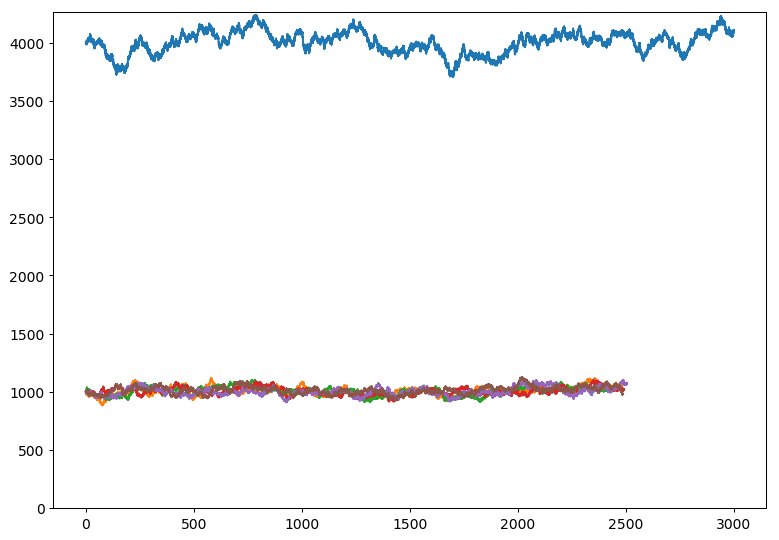

In [102]:
plt.plot(signal['timestamps'], signal['components']['S'])
plt.ylim(0,None)
for response in responses:
    plt.plot(response['timestamps'], response['components']['X'])

In [101]:
variance = []
for i in range(30):
    signal = analyzer.load_trajectory(Path('/data/signal/sig{}.traj'.format(i)))
    variance.append(np.var(signal['components']['S'][::1000]))
np.array(variance).std()

1819.5531275592243

In [106]:
from analyzer.ornstein_uhlenbeck import generate
corr_time = 1
diff_const = 0.285
generate(np.linspace(0, 1000, 1000000), 0, corr_time, diff_const, mean=0)[::1000].var(), corr_time * diff_const

(0.27693800082838527, 0.285)

In [97]:
signal['components']['S'][::10000]

array([4000.        , 3872.1097009 , 3882.27364466, 3883.30806235,
       4059.51643523, 4080.95057292, 4051.11453995, 4136.9556344 ,
       4170.45818198, 3993.70973701, 4084.1138415 , 4020.07931974,
       4097.94836113, 4073.5102347 , 3925.27479799, 3946.32393728,
       4056.36082964, 3719.61015118, 3872.26306693, 3813.24658659,
       4011.9262731 , 3999.73391582, 4048.91473388, 4037.87627053,
       3995.96850478, 4074.7145511 , 3933.02383754, 4001.23749819,
       4010.11003992, 4124.67572393])

In [90]:
import importlib
importlib.reload(analyzer)
importlib.reload(analyzer.ornstein_uhlenbeck);